In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import tempfile
import logging
import time
import datetime

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
# reinforcement learning
import gym
from gym import error, spaces, utils
from gym.utils import seeding

from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, BatchNormalization, Conv1D, InputLayer, Dropout, regularizers, Conv2D, Reshape
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu

Using TensorFlow backend.


In [3]:
import os
os.sys.path.append(os.path.abspath('.'))
%reload_ext autoreload
%autoreload 2

In [4]:
window_length = 50
batch_size=250
save_path= 'outputs/agent_portfolio-ddpg-keras/{}_weights.h5f'.format('2017-07-21_')
save_path

'outputs/agent_portfolio-ddpg-keras/2017-07-21__weights.h5f'

# Environment

You can see the base environment class [here](https://github.com/openai/gym/blob/master/gym/core.py#L13) and openai's nice docs [here](https://gym.openai.com/docs). My environment is in `src/environments/portfolio.py` and the PortfolioEnvironment load a datasource and simulation subclass.


In [5]:
from src.environments.portfolio import PortfolioEnv

In [6]:
df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
env = PortfolioEnv(
    df=df_train,
    steps=1440, 
    scale=True, 
    augment=0.0000, # let just overfit first,
    trading_cost=0, # let just overfit first,
    window_length = window_length,
    
)
env.seed = 0   

df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
env_test = PortfolioEnv(
    df=df_test,
    steps=1440, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
)
env_test.seed = 0  

# Model

arXiv:1612.01277 indicated that CNN's are just as effective. That's great because I like them, they are fast so I can try more things and see the results faster. So we will be using a CNN model.


In [7]:
from keras.layers import Input, merge, Reshape
from keras.layers import concatenate, Conv2D
from keras.regularizers import l2, l1_l2
from keras.models import Model

window_length=50
nb_actions=env.action_space.shape[0]
reg=1e-8

# Simple CNN actor model
actor = Sequential()
actor.add(InputLayer(input_shape=(1,)+env.observation_space.shape))
actor.add(Reshape(env.observation_space.shape))
actor.add(Conv2D(
    filters=2,
    kernel_size=(1,3),
    kernel_regularizer=l2(reg),
    activation='elu'
))
actor.add(BatchNormalization()) # lets add batch norm to decrease training time

actor.add(Conv2D(
    filters=20,
    kernel_size=(1,window_length-2),
    kernel_regularizer=l2(reg),
    activation='elu'
))
actor.add(BatchNormalization())

actor.add(Conv2D(
    filters=1,
    kernel_size=(1,1),
    kernel_regularizer=l2(reg),
    activation='elu'
))
actor.add(BatchNormalization())

actor.add(Flatten())
actor.add(Dense(
    nb_actions, 
    kernel_regularizer=l2(reg)
)) # this adds cash bias
actor.add(Activation('softmax'))
print(actor.summary())

# Lets have nice flexible critic so it can approximate the Q-function
action_input = Input(shape=(nb_actions,), name='action_input')

observation_input = Input(shape=(1,)+env.observation_space.shape, name='observation_input')
y = Reshape(env.observation_space.shape)(observation_input)

y = Conv2D(
    filters=2,
    kernel_size=(1,3),
    kernel_regularizer=l2(reg),
    activation='elu'
)(y)
y = BatchNormalization()(y) # lets add batch norm to decrease training time

y = Conv2D(
    filters=20,
    kernel_size=(1,window_length-2),
    kernel_regularizer=l2(reg),
    activation='elu'
)(y)
y = BatchNormalization()(y)

y = Flatten()(y)

x = concatenate([action_input, y])
x = Dense(64)(x)
x = Activation('elu')(x)
x = BatchNormalization()(x)

x = Dense(32)(x)
x = Activation('elu')(x)
x = BatchNormalization()(x)

x = Dense(16)(x)
x = Activation('elu')(x)
x = BatchNormalization()(x)

x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 5, 50, 3)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 50, 3)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 48, 2)          20        
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 48, 2)          8         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 1, 20)          1940      
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 1, 20)          80        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 1, 1)           21        
__________

# Agent

In [8]:
# # prioritised experience memory, lets make the tensorforce one work for keras-rl
# # https://github.com/matthiasplappert/keras-rl/blob/master/rl/memory.py#L115
# # https://github.com/reinforceio/tensorforce/blob/master/tensorforce/core/memories/prioritized_replay.py
# from tensorforce.core.memories import PrioritizedReplay
# from collections import namedtuple
# Experience = namedtuple('Experience',
#                         'state0, action, reward, state1, terminal1')


# class KRLPrioritizedReplay(PrioritizedReplay):
#     def get_recent_state(self, current_observation):
#         return current_observation

#     def sample(self, batch_size, batch_idxs=None):
#         tensorforce_batch = super().get_batch(batch_size)
#         experiences = []
#         # now convert dict(states=states, actions=actions, rewards=rewards, terminals=terminals, internals=internals)
#         # into Experience = namedtuple('Experience', 'state0, action, reward, state1, terminal1')
#         for i in range(len(tensorforce_batch['states'])-1):
#             experiences.append(
#                 Experience(
#                     state0=tensorforce_batch['states'][i],
#                     action=tensorforce_batch['action'][i],
#                     reward=tensorforce_batch['reward'][i],
#                     state1=tensorforce_batch['states'][i+1],
#                     terminal1=tensorforce_batch['terminals'][i+1],
#                 ))
#         return experiences

#     def append(self, observation, action, reward, terminal, training=True):
#         """Backwards: Store most recent experience in memory."""
#         actions = dict([(name, action[i]) for i, name in enumerate(self.action_spec.keys())])
#         states = dict([(name, state[i]) for i, name in enumerate(self.state_spec.keys())])
#         return super().add_observation(
#             state=states,
#             action=actions,
#             reward=reward,
#             terminal=terminal,
#             internal=[])

#     @property
#     def nb_entries(self):
#         return len(self.observations)

#     def get_config(self):
#         config = {
#             'window_length': self.window_length,
#             'ignore_episode_boundaries': self.ignore_episode_boundaries,
#             'limit': self.limit
#         }
#         return config
    
    
# # test
# from tensorforce.config import Configuration
# # Configuration.from_json
# states={
#     'state':dict(shape=tuple(env.observation_space.shape), type='float'),
# }
# actions={'action' + str(n): dict(continuous=True) for n in range(env.action_space.shape[0])}
# config = Configuration(
#     states=states,
#     actions=actions,
# )

# from rl.memory import SequentialMemory
# memory0 = SequentialMemory(limit=10000, window_length=1)
# memory1 = KRLPrioritizedReplay(
#     capacity=10000,
#     states_config=config.states,
#     actions_config=config.actions,
#     prioritization_weight=1.0
# )


# observation = np.zeros(states['state']['shape'])
# action = [0.5 for i in actions]
# reward=0.5
# terminal=False

# for _ in range(10):
#     memory0.append(observation, action, reward, terminal, training=True)
#     state0 = memory0.get_recent_state(observation)
# sample0 = memory0.sample(1)


# for _ in range(10):
#     memory1.append(observation, action, reward, terminal, training=True)
#     state1 = memory1.get_recent_state(observation)
# sample1 = memory1.sample(1)

# assert sample0==sample1


# TODO make batch return state1 https://github.com/matthiasplappert/keras-rl/blob/master/rl/memory.py#L153

In [9]:
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

# We configure and compile our agent.

# We are providing the last 50 steps so we don't need memory, use window_lenght=1 as placeholder
memory = SequentialMemory(limit=100000, window_length=1)

random_process = OrnsteinUhlenbeckProcess(
    size=nb_actions, theta=.15, mu=0., sigma=.1)

agent = DDPGAgent(
    nb_actions=nb_actions,
    actor=actor,
    critic=critic,
    critic_action_input=action_input,
    random_process=random_process,
    memory=memory,
    batch_size=batch_size,
    nb_steps_warmup_critic=150,
    nb_steps_warmup_actor=150,    
    gamma=.00, # discounted factor of zero as per paper
    target_model_update=1e-3
)

# agent.compile(Adam(lr=3e-5), metrics=['mse'])
# agent.compile(Adam(lr=1e-3), metrics=['mse'])
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
agent

# Train

In [10]:
from src.callbacks.keras_rl_callbacks import TrainIntervalLoggerTQDMNotebook

In [11]:
def sharpe(returns, freq=30, rfr=0):
    """Given a set of returns, calculates naive (rfr=0) sharpe (eq 28) """
    return (np.sqrt(freq) * np.mean(returns-rfr)) / np.std(returns - rfr)


def MDD(returns):
    """Max drawdown."""
    peak = returns.max()
    i = returns.argmax()
    trough = returns[returns.argmax():].min()
    return (trough-peak)/trough 

In [12]:
# # https://github.com/matthiasplappert/keras-rl/blob/master/rl/callbacks.py#L104
from rl.callbacks import TrainEpisodeLogger
class TrainEpisodeLoggerPortfolio(TrainEpisodeLogger):
    """Print custom stats every <log_intv> episode."""
    def __init__(self, log_intv):
        super().__init__()
        self.log_intv=log_intv
        self.episode_metrics={} # custom metrics
    def on_episode_end(self, episode, logs):
        
        # save custom metrics
        df = pd.DataFrame(self.env.infos)
        self.episode_metrics[episode]=dict(
            max_drawdown=MDD(df.portfolio_value), 
            sharpe=sharpe(df.rate_of_return), 
            accumulated_portfolio_value=df.portfolio_value.iloc[-1],
            mean_market_return=df.mean_market_returns.cumprod().iloc[-1],
            cash_bias=df.weights.apply(lambda x:x[0]).mean()
        )
        
        if episode%self.log_intv==0:
            # print normal metrics
            super().on_episode_end(episode, logs)
            
            # print custom metrics for last N episodes
            df = pd.DataFrame(self.episode_metrics).T[-self.log_intv:]          
            for col in df.columns:
                print('{name:25.25s}: {mean: 10.6f} [{min: 10.6f}, {max: 10.6f}]'.format(
                    name=df[col].name, 
                    min=df[col].min(), 
                    mean=df[col].mean(), 
                    max=df[col].max(), 
                ))
            print('')           
        

In [13]:
from rl.callbacks import ModelIntervalCheckpoint


In [14]:
agent.load_weights(save_path)

In [ ]:
history = agent.fit(env, 
                  nb_steps=2e6, 
                  visualize=False, 
                  verbose=0,
                  callbacks=[
                      TrainIntervalLoggerTQDMNotebook(),
                      TrainEpisodeLoggerPortfolio(10),
                      ModelIntervalCheckpoint(save_path, 10*1440, 1)
                    ]
                 )

# After training is done, we save the final weights.
agent.save_weights(save_path, overwrite=True)

Training for 2000000.0 steps ...
Training for 2000000.0 steps ...
Interval 1 (0 steps performed)


/home/wassname/.pyenv/versions/3.6.2/envs/jupyter3/lib/python3.6/site-packages/rl/memory.py:29: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


    1440/2000000.0: episode: 1, duration: 143.614s, episode steps: 1440, steps per second: 10, episode reward: 0.000, mean reward: 0.000 [-0.000, 0.000], mean action: 0.137 [-0.452, 1.292], mean observation: 0.998 [0.712, 1.470], loss: 0.000000, mean_absolute_error: 0.000081, mean_q: -0.000000
accumulated_portfolio_val:   1.600968 [  1.600968,   1.600968]
cash_bias                :   0.055785 [  0.055785,   0.055785]
max_drawdown             :  -0.000012 [ -0.000012,  -0.000012]
mean_market_return       :   1.780263 [  1.780263,   1.780263]
sharpe                   :   0.273345 [  0.273345,   0.273345]

6 episodes - episode_reward: 0.000 [-0.000, 0.001] - loss: 0.000 - mean_absolute_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.214 - rate_of_return: 0.000 - cost: 0.000 - steps: 716.060 - cash_bias: 0.084 - mean_market_returns: 1.000

Interval 2 (10000 steps performed)
Step 14400: saving model to outputs/agent_portfolio-ddpg-keras/2017-07-21__weig

7 episodes - episode_reward: 0.000 [-0.000, 0.001] - loss: 0.000 - mean_absolute_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.304 - rate_of_return: 0.000 - cost: 0.000 - steps: 722.460 - cash_bias: 0.078 - mean_market_returns: 1.000

Interval 12 (110000 steps performed)
Step 115200: saving model to outputs/agent_portfolio-ddpg-keras/2017-07-21__weights.h5f
  116640/2000000.0: episode: 81, duration: 157.071s, episode steps: 1440, steps per second: 9, episode reward: 0.000, mean reward: 0.000 [-0.000, 0.000], mean action: 0.122 [-0.510, 1.223], mean observation: 1.001 [0.766, 1.257], loss: 0.000000, mean_absolute_error: 0.000114, mean_q: 0.000000
accumulated_portfolio_val:   1.650479 [  0.902475,   3.011151]
cash_bias                :   0.055152 [  0.008750,   0.161314]
max_drawdown             :  -0.231918 [ -0.710915,  -0.009612]
mean_market_return       :   1.664031 [  1.137732,   2.347613]
sharpe                   :   0.187749 [ -0.040975,   0

Step 216000: saving model to outputs/agent_portfolio-ddpg-keras/2017-07-21__weights.h5f
  217440/2000000.0: episode: 151, duration: 156.252s, episode steps: 1440, steps per second: 9, episode reward: -0.000, mean reward: -0.000 [-0.000, 0.000], mean action: 0.157 [-0.427, 1.438], mean observation: 1.000 [0.692, 1.309], loss: 0.000000, mean_absolute_error: 0.000115, mean_q: 0.000000
accumulated_portfolio_val:   1.008778 [  0.380107,   1.715898]
cash_bias                :   0.050137 [  0.008341,   0.111793]
max_drawdown             :  -0.679917 [ -1.988953,  -0.018552]
mean_market_return       :   1.369305 [  0.479848,   2.661585]
sharpe                   :   0.003775 [ -0.469765,   0.310177]

7 episodes - episode_reward: 0.000 [-0.000, 0.001] - loss: 0.000 - mean_absolute_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.218 - rate_of_return: 0.000 - cost: 0.000 - steps: 717.980 - cash_bias: 0.028 - mean_market_returns: 1.000

Interval 23 (220000 step

7 episodes - episode_reward: 0.000 [-0.000, 0.001] - loss: 0.000 - mean_absolute_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.181 - rate_of_return: 0.000 - cost: 0.000 - steps: 724.380 - cash_bias: 0.039 - mean_market_returns: 1.000

Interval 33 (320000 steps performed)
7 episodes - episode_reward: 0.000 [-0.000, 0.001] - loss: 0.000 - mean_absolute_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.397 - rate_of_return: 0.000 - cost: 0.000 - steps: 725.020 - cash_bias: 0.091 - mean_market_returns: 1.000

Interval 34 (330000 steps performed)
Step 331200: saving model to outputs/agent_portfolio-ddpg-keras/2017-07-21__weights.h5f
  332640/2000000.0: episode: 231, duration: 135.652s, episode steps: 1440, steps per second: 11, episode reward: -0.000, mean reward: -0.000 [-0.000, 0.000], mean action: 0.103 [-0.464, 1.124], mean observation: 1.001 [0.161, 1.203], loss: 0.000000, mean_absolute_error: 0.000115, mean_q:

7 episodes - episode_reward: 0.000 [-0.000, 0.001] - loss: 0.000 - mean_absolute_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.350 - rate_of_return: 0.000 - cost: 0.000 - steps: 719.900 - cash_bias: 0.030 - mean_market_returns: 1.000

Interval 44 (430000 steps performed)
Step 432000: saving model to outputs/agent_portfolio-ddpg-keras/2017-07-21__weights.h5f
  433440/2000000.0: episode: 301, duration: 159.085s, episode steps: 1440, steps per second: 9, episode reward: 0.000, mean reward: 0.000 [-0.000, 0.000], mean action: 0.116 [-0.322, 1.201], mean observation: 1.004 [0.763, 1.483], loss: 0.000000, mean_absolute_error: 0.000104, mean_q: -0.000000
accumulated_portfolio_val:   1.528060 [  0.945644,   2.593394]
cash_bias                :   0.035942 [  0.010315,   0.072050]
max_drawdown             :  -0.272870 [ -0.945046,   0.000000]
mean_market_return       :   1.671359 [  1.310089,   2.087434]
sharpe                   :   0.186077 [  0.007315,  

In [ ]:
agent.save_weights('outputs/agent_portfolio-ddpg-keras/agent_{}_weights.h5f'.format('portfolio-ddpg-keras-rl'), overwrite=True)

# Test

Testing for 1 episodes ...
Episode 1: reward: 0.001, steps: 7613
APV (Accumulated portfolio value): 	 181.388076
SR (Sharpe ratio):                 	 0.262592
MDD (max drawdown):                	-37.740168%
MDR (mean_market_return):          	 27.985419



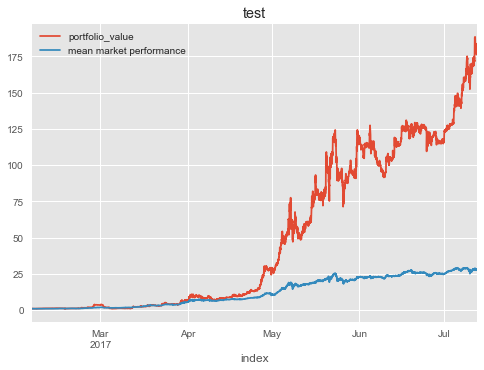

In [24]:
# one big test
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
steps=len(df_test)-window_length-2
env_test = PortfolioEnv(
    df=df_test,
    steps=steps, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
)
env_test.seed = 0  
agent.test(env_test, nb_episodes=1, visualize=False)

df = pd.DataFrame(env_test.infos)
df.index=df['index']

s=sharpe(df.rate_of_return)
mdd=MDD(df.rate_of_return+1)
mean_market_return=df.mean_market_returns.cumprod().iloc[-1]
print('APV (Accumulated portfolio value): \t{: 2.6f}'.format(df.portfolio_value.iloc[-1]))
print('SR (Sharpe ratio):                 \t{: 2.6f}'.format( s))
print('MDD (max drawdown):                \t{: 2.6%}'.format( mdd))
print('MDR (mean_market_return):          \t{: 2.6f}'.format( mean_market_return))
print('')

# show one run vs average market performance
df.portfolio_value.plot()
df.mean_market_returns.cumprod().plot(label='mean market performance')
plt.legend()
plt.title('test')

In [ ]:
# The weights appear to be static, so the model hasn't learnt much :(
df = pd.DataFrame(env_test.infos)
df.index=df['index']
df.weights

index
2017-02-04 08:00:00                       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2017-02-04 08:30:00    [0.00731654, 0.0315146, 0.938596, 0.00170927, ...
2017-02-04 09:00:00    [0.0190743, 0.0924498, 0.860992, 0.00979124, 0...
2017-02-04 09:30:00    [0.0421061, 0.105747, 0.763996, 0.0302245, 0.0...
2017-02-04 10:00:00    [0.0448445, 0.204392, 0.676664, 0.0264077, 0.0...
2017-02-04 10:30:00    [0.0150724, 0.0820092, 0.88418, 0.00701311, 0....
2017-02-04 11:00:00    [0.0027137, 0.00291277, 0.985919, 0.000439721,...
2017-02-04 11:30:00    [0.00245529, 0.00190385, 0.988684, 0.000299987...
2017-02-04 12:00:00    [0.012495, 0.0137654, 0.960403, 0.00298369, 0....
2017-02-04 12:30:00    [0.00887985, 0.0155681, 0.96558, 0.00264909, 0...
2017-02-04 13:00:00    [0.00138628, 0.000568855, 0.993987, 0.00014884...
2017-02-04 13:30:00    [0.00226571, 0.000596184, 0.989777, 0.00020279...
2017-02-04 14:00:00    [0.00510076, 0.0015662, 0.986997, 0.000913473,...
2017-02-04 14:30:00    [0.00499729, 0.0008911

In [ ]:
# on the training interval
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='train')
steps=len(df_test)-window_length-2
env_test = PortfolioEnv(
    df=df_test,
    steps=steps, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
)
env_test.seed = 0  
agent.test(env_test, nb_episodes=1, visualize=False)

df = pd.DataFrame(env_test.infos)
df.index=df['index']

s=sharpe(df.rate_of_return)
mdd=MDD(df.rate_of_return+1)
mean_market_return=df.mean_market_returns.cumprod().iloc[-1]
print('APV (Accumulated portfolio value): \t{: 2.6f}'.format(df.portfolio_value.iloc[-1]))
print('SR (Sharpe ratio):                 \t{: 2.6f}'.format( s))
print('MDD (max drawdown):                \t{: 2.6%}'.format( mdd))
print('MDR (mean_market_return):          \t{: 2.6f}'.format( mean_market_return))
print('')

# show one run vs average market performance
df.portfolio_value.plot()
df.mean_market_returns.cumprod().plot(label='mean market performance')
plt.legend()
plt.title('training data')

Testing for 1 episodes ...


In [ ]:
# Lets evaluate a few 30 step intervals
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
env_test = PortfolioEnv(
    df=df_test,
    steps=30, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
)
env_test.seed = 0  

for i in range(10):
    agent.test(env_test, nb_episodes=1, visualize=False)
    df = pd.DataFrame(env_test.infos)
    s=sharpe(df.rate_of_return)
    mdd=MDD(df.rate_of_return+1)
    mean_market_return=df.mean_market_returns.cumprod().iloc[-1]
    print('APV (Accumulated portfolio value): \t{: 2.6f}'.format(df.portfolio_value.iloc[-1]))
    print('MMR (mean_market_return):          \t{: 2.6f}'.format(mean_market_return))    
    print('SR (Sharpe ratio):                 \t{: 2.6f}'.format( s))
    print('MDD (max drawdown):                \t{: 2.6%}'.format( mdd))
    print('')
    df.portfolio_value.plot(label=str(i))
plt.legend()

# Visualise

In [18]:
# history
df_hist = pd.DataFrame(history.history)
df_hist
df_hist['episodes'] = df_hist.index

g = sns.jointplot(x="episodes", y="episode_reward", data=df_hist, kind="reg", size=10)
plt.show()

# g = sns.jointplot(x="episodes", y="rewards", data=history, kind="reg")

NameError: name 'history' is not defined